In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import evaluate

In [51]:
api = wandb.Api()

In [52]:
metric = evaluate.combine(["precision", "recall", "accuracy", "f1"])

In [53]:
def download_predictions(run_name: str, invert:bool = False) -> tuple[dict]:
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

    for run in runs:
        if run.state == 'finished':
            for art in run.logged_artifacts():
                if "test_predictions" in art.name:
                    artifact = api.artifact(f"{wandb_project_base}/{art.name}")
                    path = artifact.download()
                    labels = np.load(path + '/labels.npy')
                    predictions = np.load(path + '/predictions.npy')
                    # Apply softmax to prediction logits using torch
                    predictions_t = torch.tensor(predictions)
                    probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                    predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                    # Invert if desired
                    if invert:
                        predictions = np.abs(predictions - 1)

                    ret.append({
                        'run_name': run_name,
                        'artifact_name': art.name,
                        'predictions': predictions,
                        'labels': labels})
    
    return tuple(ret)

In [76]:
def plot_predictions(predictions: dict):
    conf_mats_ct24 = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in predictions]
    fig, axes = plt.subplots(1, len(conf_mats_ct24), figsize=(15, 5))
    fig.suptitle(predictions[0]["run_name"], fontsize=16)

    if len(conf_mats_ct24) == 1:
        # Wrap in array if single axes so we can iter
        axes = [axes]

    for ax, cm, preds in zip(axes, conf_mats_ct24, predictions):
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax)
        ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

    metrics = [metric.compute(predictions=preds["predictions"], references=preds["labels"]) for preds in predictions]
    metrics_frame = pd.DataFrame(metrics)
    print(metrics_frame)
    print("--mean--")
    print(metrics_frame.mean())

In [55]:
def get_misclassified_samples(predictions: np.array, data_path: str, trunc_data: int | bool = False):
    # Load the dataframe from the provided data path
    df = pd.read_csv(data_path)

    if trunc_data:
        df = df.head(trunc_data)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    df['class_label'] = df['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = df[df['class_label'] != predictions]
    
    return misclassified_samples

In [ ]:
from collections import Counter

def intersect_misclassifications(misclassified: list[pd.DataFrame], min_num_misclassified: int):
    # Combine all misclassified dataframes into a single dataframe with an identifier for each dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

In [57]:
invert = False
predictions_ct24 = download_predictions("ct24_general_claim_eval", invert=invert)
predictions_ct24_double = download_predictions("ct24_double_general_claim_eval", invert=invert)

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


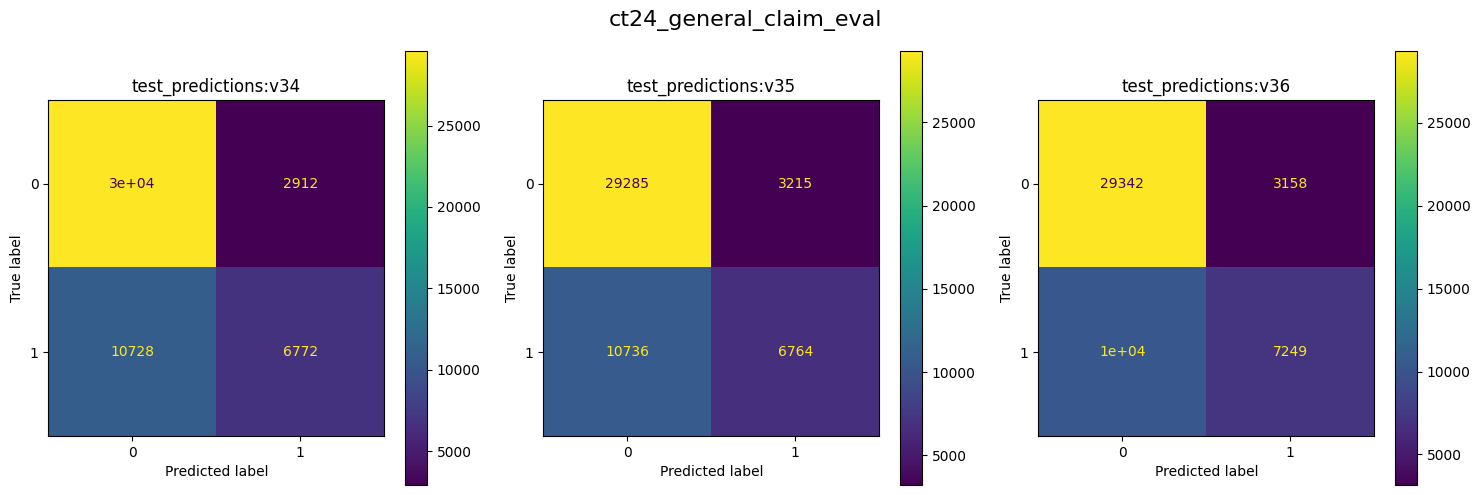

   precision    recall  accuracy        f1
0   0.699298  0.386971   0.72720  0.498234
1   0.677823  0.386514   0.72098  0.492303
2   0.696550  0.414229   0.73182  0.519511
--mean--
precision    0.691224
recall       0.395905
accuracy     0.726667
f1           0.503350
dtype: float64


In [77]:
plot_predictions(predictions_ct24)

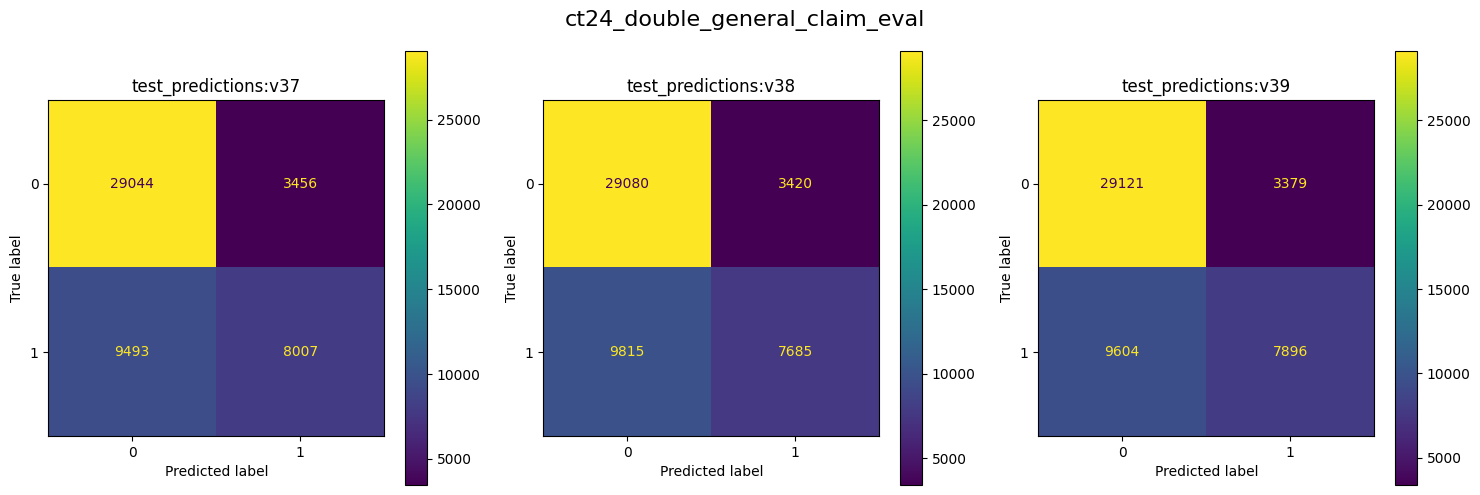

   precision    recall  accuracy        f1
0   0.698508  0.457543   0.74102  0.552912
1   0.692031  0.439143   0.73530  0.537319
2   0.700310  0.451200   0.74034  0.548810
--mean--
precision    0.696950
recall       0.449295
accuracy     0.738887
f1           0.546347
dtype: float64


In [78]:
plot_predictions(predictions_ct24_double)

In [96]:
eval_file_path = "../data/general_claim/general-claim-filtered.csv"
misclassified_ct24 = [get_misclassified_samples(preds["predictions"], eval_file_path, trunc_data=50000) for preds in predictions_ct24]
misclassified_ct24_double = [get_misclassified_samples(preds["predictions"], eval_file_path, trunc_data=50000) for preds in predictions_ct24_double]

In [ ]:
intersect_misclassifications(misclassified_ct24, min_num_misclassified=len(misclassified_ct24))

,Sentence_id,topic,style,source,class_label,Text
0,349195,politics,structured,various,0,"The plutonium , stripped out of American nucle..."
1,433583,various,semi,Fact-Checks,1,Korean newscaster bursts out laughing while re...
2,567704,various,semi,Fact-Checks,1,Image shows an elephant beaten in Tamil Nadu
3,599612,politics,semi,PolitiFact,0,Downstream Gas operates across the gas value c...
4,476682,various,semi,Fact-Checks,1,"""I am certain we won't be denied the World Cup.”"
...,...,...,...,...,...,...
13634,433595,various,semi,Fact-Checks,1,Snowfall in Lagos
13636,114178,various,semi,LiveJournal,1,: ' ( It ' s pretty hopeless . . .
13637,411292,various,semi,Fact-Checks,1,"""Nobody"" in the Republican Party ""condemns"" th..."
13638,335840,various,structured,Persuasive Essay,1,"Because of that , tourism should not be alledg..."
